In [1]:
import os
import numpy as np 
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator instance
image_gen = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

# Load training data
train_flow = image_gen.flow_from_directory(
    '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'  # Use the training subset
)

# Load validation data
valid_flow = image_gen.flow_from_directory(
    '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/valid',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Use the validation subset
)

# Load test data
test_flow = ImageDataGenerator(rescale=1.0/255).flow_from_directory(
    '/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/test',
    target_size=(224, 224),
    batch_size=1,
    shuffle=False,
    class_mode='binary'
)


Found 80000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


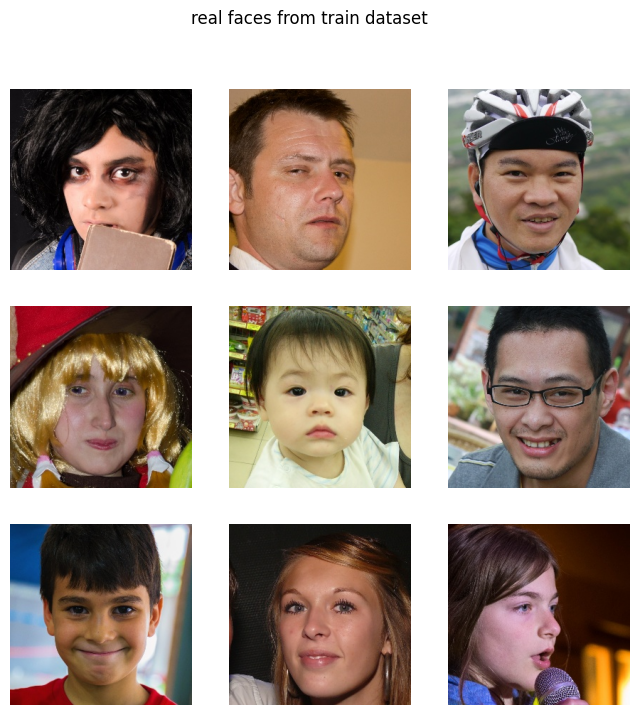

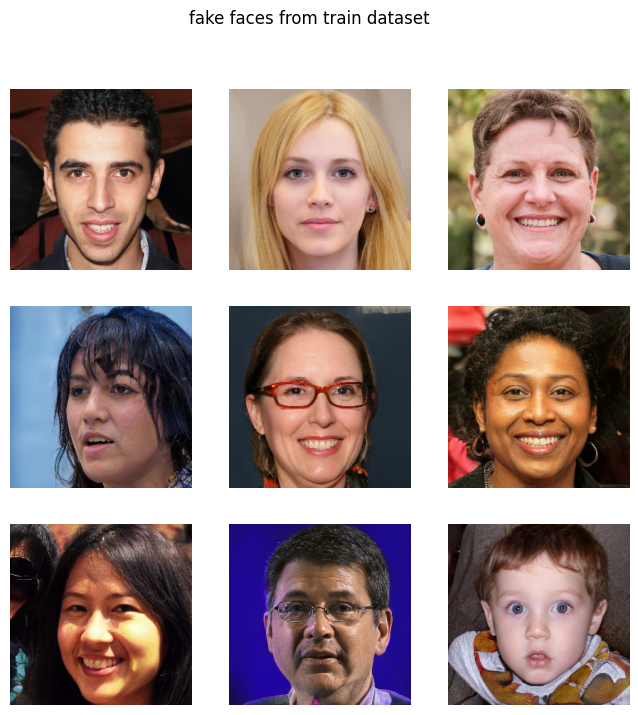

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

# Plotting real and fake faces from the dataset
def plot_img(path, set_):
    dir_ = os.path.join(path, set_)  # Path to the 'real' or 'fake' folder inside 'train'
    file_list = os.listdir(dir_)  # Get all files in the directory
    k = np.random.randint(len(file_list))  # Generate a random index to pick an image
    
    fig, ax = plt.subplots(3, 3, figsize=(8, 8))
    for j in range(3):
        for i in range(3):
            img_path = os.path.join(dir_, file_list[k])  # Get the full image path
            img = load_img(img_path)  # Load the image
            ax[j, i].imshow(img)
            ax[j, i].set_title("")
            ax[j, i].axis('off')
            k = np.random.randint(len(file_list))  # Randomly pick the next image
    plt.suptitle(set_ + ' faces from train dataset')
    return plt

# Call the function to plot images
plot_img('/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train', 'real').show()
plot_img('/kaggle/input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/train', 'fake').show()


In [4]:
# CNN Model Architecture
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(layers.BatchNormalization(input_shape=input_shape))
    model.add(layers.Conv2D(16, 3, activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(2))
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2D(32, 3, activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1))

    model.add(layers.Conv2D(64, 3, activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1))

    model.add(layers.Conv2D(128, 3, activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1))

    model.add(layers.Conv2D(256, 3, activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1))

    model.add(layers.Conv2D(512, 3, activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1))

    model.add(layers.Conv2D(1024, 3, activation='relu', padding='same'))
    model.add(layers.MaxPooling2D(2))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.1))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Create CNN Model
cnn_model = create_cnn_model((224, 224, 3))
cnn_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
# Train CNN Model with Model Checkpointing
history = cnn_model.fit(
    train_flow,
    epochs=6,
    validation_data=valid_flow,
    callbacks=[ModelCheckpoint(
        "saved-cnn-model.keras", 
        monitor='val_accuracy', 
        save_best_only=True, 
        mode='max')
    ]
)

# Load the saved models
model_path = '/kaggle/working/saved-cnn-model.keras'  # Change path according to Kaggle environment
best_cnn_model = load_model(model_path)

# Extracting loss and accuracy data from the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Epoch 1/6


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 513s 199ms/step - accuracy: 0.6952 - loss: 0.6464 - val_accuracy: 0.7163 - val_loss: 0.6192
Epoch 2/6
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 190s 76ms/step - accuracy: 0.8391 - loss: 0.3648 - val_accuracy: 0.8142 - val_loss: 0.4283
Epoch 3/6
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 182s 72ms/step - accuracy: 0.9003 - loss: 0.2377 - val_accuracy: 0.8100 - val_loss: 0.4895
Epoch 4/6
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 181s 72ms/step - accuracy: 0.9320 - loss: 0.1699 - val_accuracy: 0.8928 - val_loss: 0.2763
Epoch 5/6
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 182s 73ms/step - accuracy: 0.9511 - loss: 0.1226 - val_accuracy: 0.8745 - val_loss: 0.3388
Epoch 6/6
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 173s 69ms/step - accuracy: 0.9626 - loss: 0.0967 - val_accuracy: 0.9170 - val_loss: 0.2231


In [6]:
# Visualization for Loss
def plot_loss(epochs, loss, val_loss):
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Visualization for Accuracy
def plot_accuracy(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

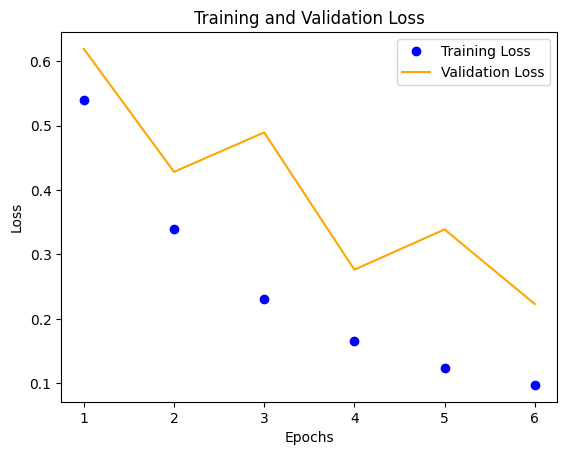

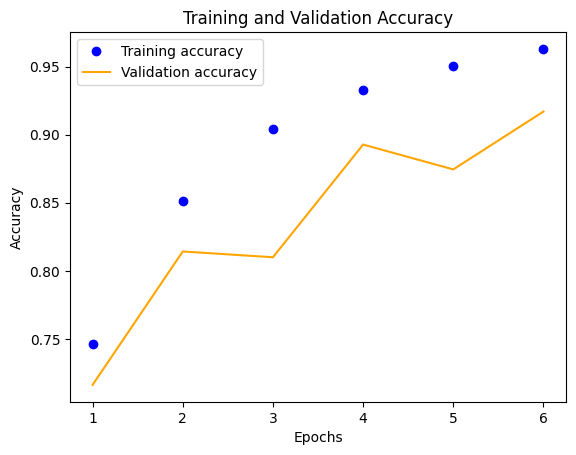

In [7]:
# Plotting Loss and Accuracy across epochs
plot_loss(range(1, len(loss) + 1), loss, val_loss)
plot_accuracy(range(1, len(loss) + 1), acc, val_acc)

In [8]:
# Predicting on the test set and obtaining the actual labels
y_pred = cnn_model.predict(test_flow)
y_test = test_flow.classes

20000/20000 ━━━━━━━━━━━━━━━━━━━━ 190s 9ms/step


In [9]:
# Generating confusion matrix and visualizing model performance
results = confusion_matrix(y_test, y_pred > 0.5)

# Define group names, counts, and percentages for annotations
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in results.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in results.flatten() / np.sum(results)]

([<matplotlib.axis.YTick at 0x7d08a11e9060>,
 [Text(0, 0, 'Fake'), Text(0, 1, 'Real')])

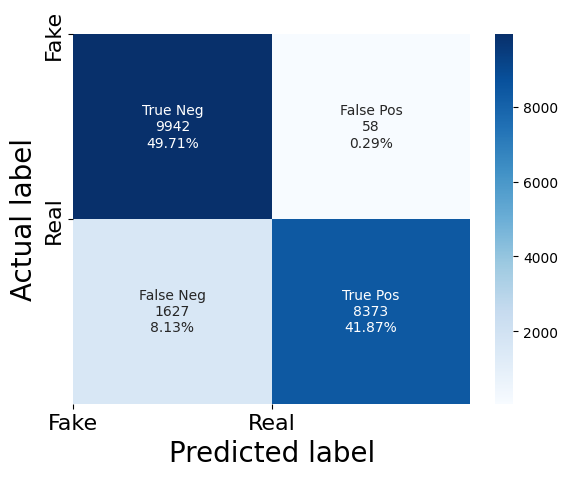

In [10]:
 #Combine group names, counts, and percentages into labels for the heatmap
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2, 2)  # Reshape labels for 2x2 confusion matrix

# Create a heatmap for visualizing the confusion matrix
sns.heatmap(results, annot=labels, fmt='', cmap='Blues')
plt.ylabel('Actual label', size=20)
plt.xlabel('Predicted label', size=20)
plt.xticks(np.arange(2), ['Fake', 'Real'], size=16)
plt.yticks(np.arange(2), ['Fake', 'Real'], size=16)

In [11]:
# Print accuracy score and classification report
print('Accuracy Score:', metrics.accuracy_score(y_test, y_pred > 0.5))
print('Report:')
print(classification_report(y_test, y_pred > 0.5))


Accuracy Score: 0.91575
Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92     10000
           1       0.99      0.84      0.91     10000

    accuracy                           0.92     20000
   macro avg       0.93      0.92      0.92     20000
weighted avg       0.93      0.92      0.92     20000



In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# Assuming test_flow is your test data generator and cnn_model is your trained model
def evaluate_model(cnn_model, test_flow):
    # Get ground truth labels and predictions
    y_true = test_flow.classes  # True labels from test generator
    y_pred_probs = cnn_model.predict(test_flow, verbose=1)  # Predicted probabilities
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # Convert probabilities to binary predictions

    # Calculate metrics
    precision = precision_score(y_true, y_pred, average='binary')  # For binary classification
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    accuracy = accuracy_score(y_true, y_pred)

    # Print the metrics
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")

    return accuracy, precision, recall, f1

# Call the function with your model and test dataset
evaluate_model(cnn_model, test_flow)


20000/20000 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step
Accuracy: 0.92
Precision: 0.99
Recall: 0.84
F1 Score: 0.91


(0.91575, 0.9931206262602301, 0.8373, 0.9085779393413272)

ROC-AUC Score: 0.9954077199999999
AP Score: 0.9952334664405394


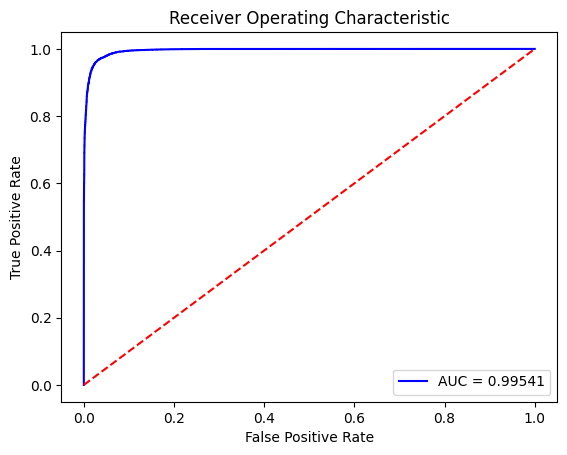

In [13]:
# Evaluate model using ROC-AUC and Average Precision scores
print("ROC-AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))

# Plot ROC Curve and calculate AUC
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.5f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')  # Diagonal line for chance level
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


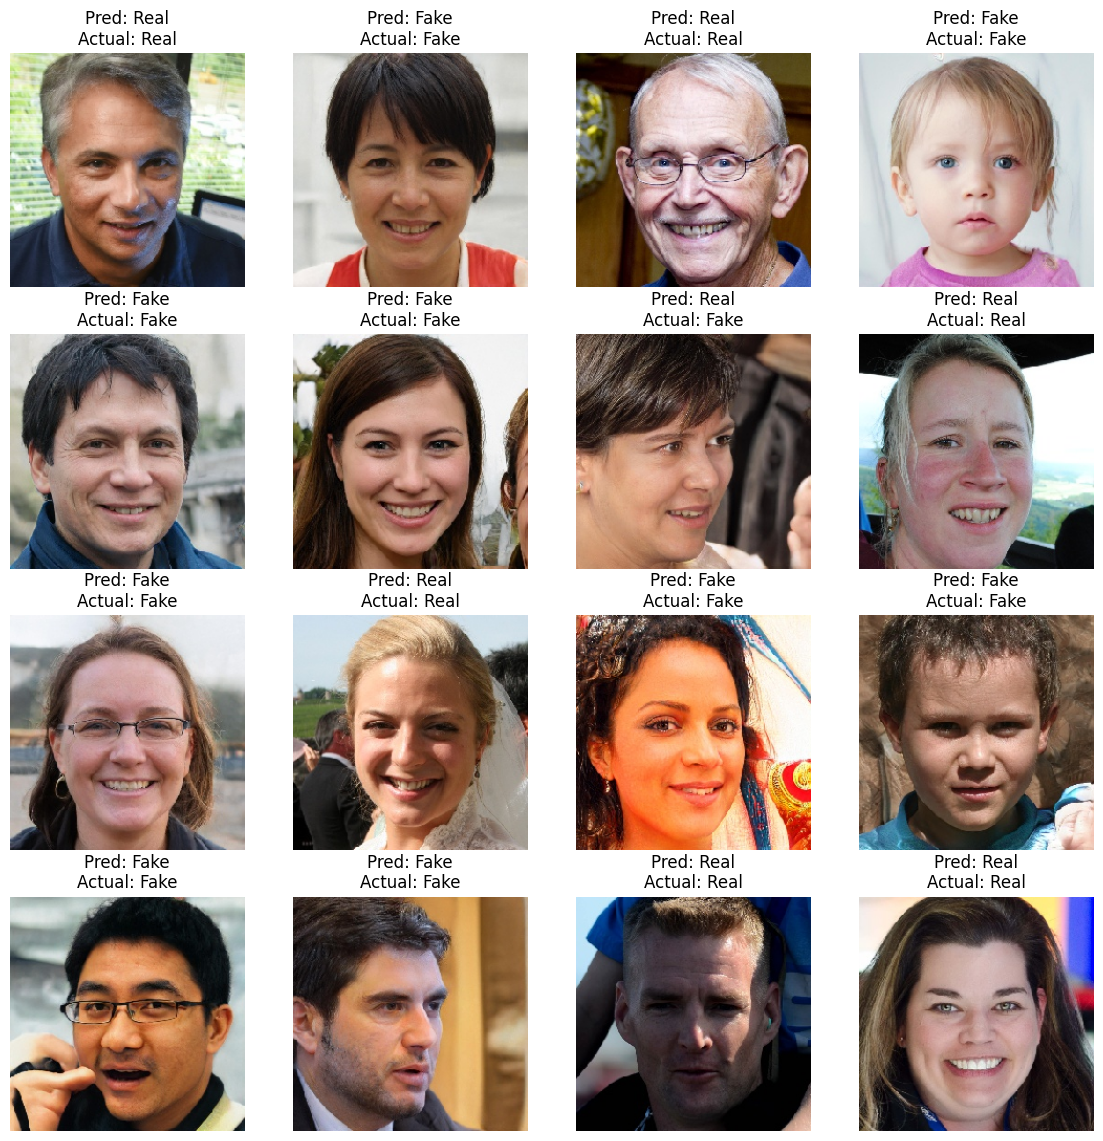

In [14]:
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Display a grid of test images with their predicted and actual classes
def predict_img_class():
    gridx = 4
    gridy = 4
    fig, ax = plt.subplots(gridx, gridy, figsize=(14, 14))
    
    # Check if the directory exists
    if not os.path.exists(test_flow.directory):
        print(f"Directory {test_flow.directory} does not exist.")
        return
    
    # Get the real and fake subdirectories
    subfolders = ['real', 'fake']
    
    # Initialize an empty list to hold file paths
    file_paths = []
    
    # Loop through real and fake subdirectories and gather image file paths
    for subfolder in subfolders:
        subfolder_path = os.path.join(test_flow.directory, subfolder)
        
        # List all image files in the subfolder
        file_list = [f for f in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, f))]
        
        # Check if the subfolder has any images
        if len(file_list) == 0:
            print(f"No image files found in {subfolder_path}.")
            continue
        
        # Add the full file path of each image to the list
        for file_name in file_list:
            file_paths.append((os.path.join(subfolder_path, file_name), subfolder))  # Tuple of file path and actual label
    
    # Shuffle the file_paths to pick images randomly
    np.random.shuffle(file_paths)
    
    # Now pick random images and display
    k = 0
    for j in range(gridx):
        for i in range(gridy):
            # Get the random image path and actual label
            img_path, actual_label = file_paths[k]
            
            # Load and predict image class
            img = load_img(img_path, target_size=(224, 224))
            img_array = img_to_array(img) / 255.0
            img_array = np.expand_dims(img_array, axis=0)
            predicted_class = cnn_model.predict(img_array)
            predicted_label = 'Real' if predicted_class > 0.5 else 'Fake'
            
            # Display image and labels
            ax[j, i].imshow(img)
            ax[j, i].set_title(f"Pred: {predicted_label}\nActual: {actual_label.capitalize()}")
            ax[j, i].axis('off')
            k += 1  # Move to the next image
    
    plt.show()

# Predict image classes from the test dataset
predict_img_class()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


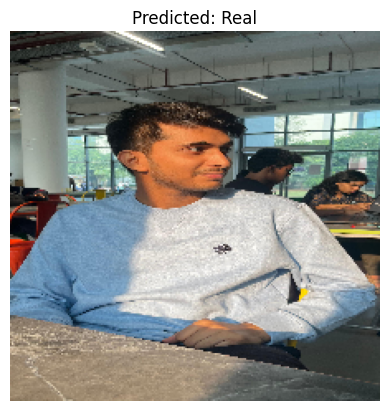

In [21]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load trained model
model_path = '/kaggle/working/saved-cnn-model.keras'
cnn_model = tf.keras.models.load_model(model_path)

# Get the first image file in the directory
image_dir = '/kaggle/input/image'  # Directory containing images
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

if not image_files:
    print("No image files found in the directory.")
else:
    image_path = os.path.join(image_dir, image_files[0])  # Pick the first image

    # Function to load and test an image from a file path
    def test_image_from_path(image_path):
        # Load and preprocess the image
        img = load_img(image_path, target_size=(224, 224))  # Resize to match model input
        img_array = img_to_array(img) / 255.0  # Normalize the image to [0, 1]
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Predict class using the loaded model
        predicted_class = cnn_model.predict(img_array)[0][0]

        # Map prediction to label
        predicted_label = 'Real' if predicted_class > 0.5 else 'Fake'

        # Display the image with the predicted label
        plt.imshow(img)
        plt.title(f"Predicted: {predicted_label}")
        plt.axis('off')
        plt.show()

    # Test the first image in the directory
    test_image_from_path(image_path)


In [23]:
cnn_model.save('/kaggle/working/my_cnn_model.h5')